In [31]:
import tensorflow as tf
import numpy as np
from model.filter import filtfilt
from itertools import chain
import pandas as pd
import os
import scipy
import scipy.io as io
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 12, 8
sns.set_context('poster')
#sns.set_context('notebook')
#sns.set(font_scale=1.3)
#sns.set_style('whitegrid')
#sns.despine(left=True,  trim=True)

In [2]:
fs = 300.
N = 200
#y_val = np.sin(np.arange(N, dtype=np.float32)/3.14)*60 + np.random.randn(N)*60
def loadmat(id):
    fname = "data/raw/training2017/A%05d.mat"%id
    y_val = io.loadmat(fname)['val'][0]
    return y_val

y_val = loadmat(1)

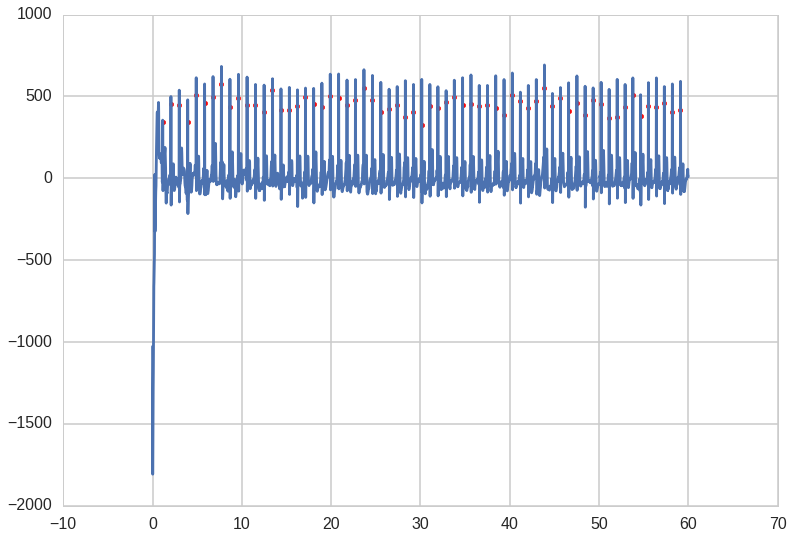

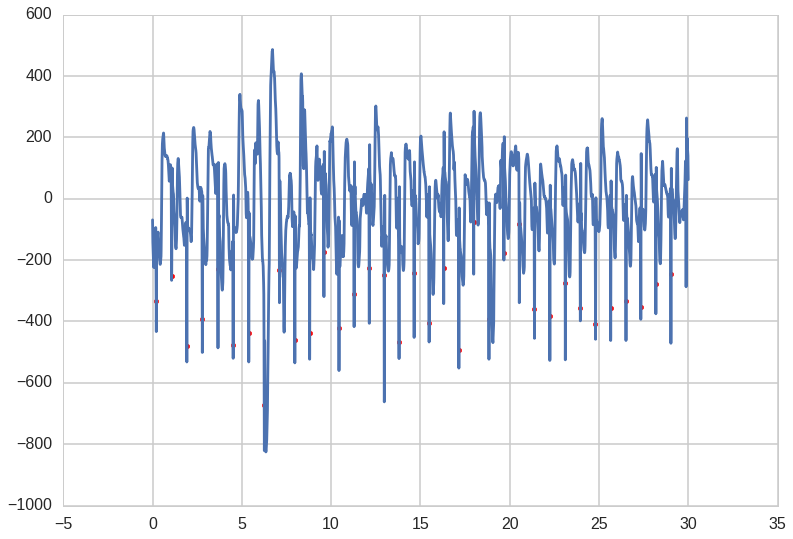

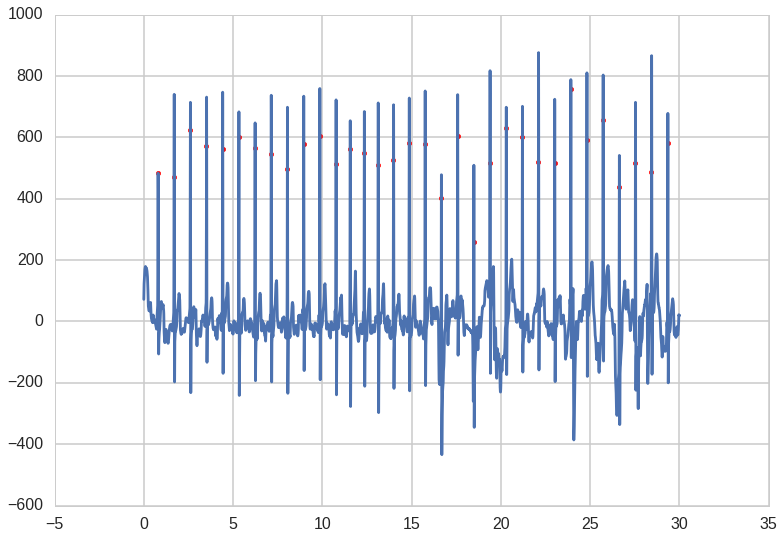

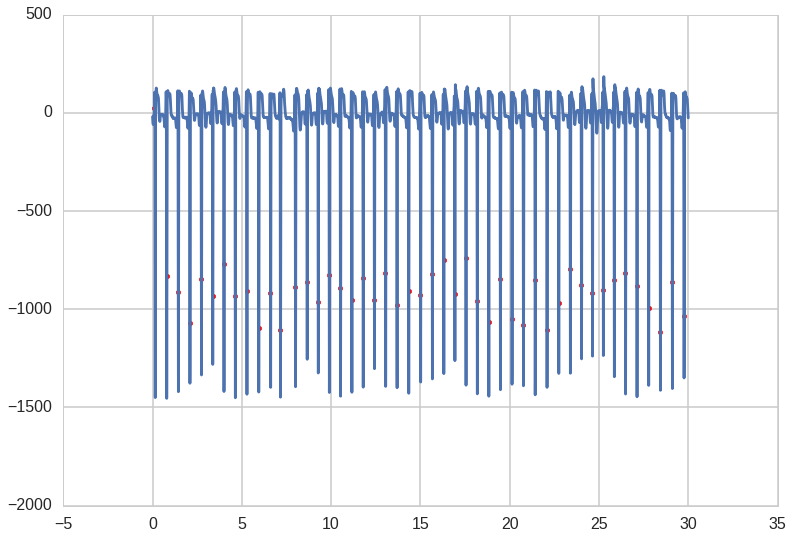

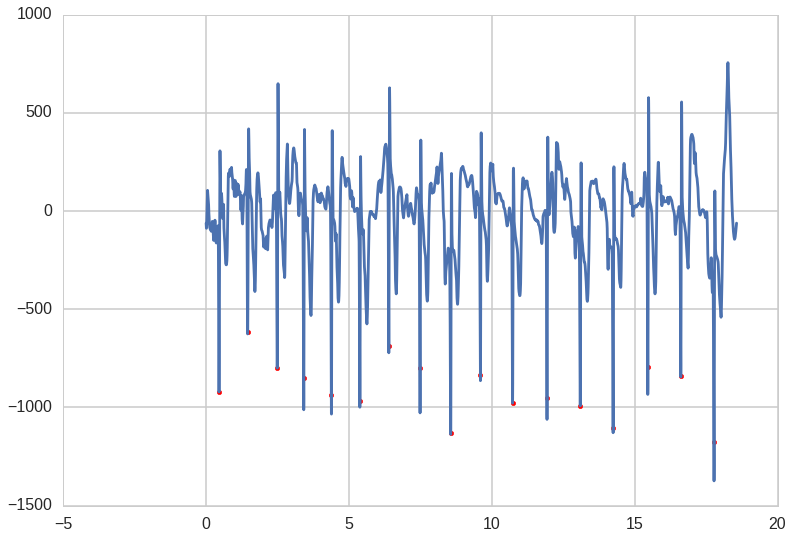

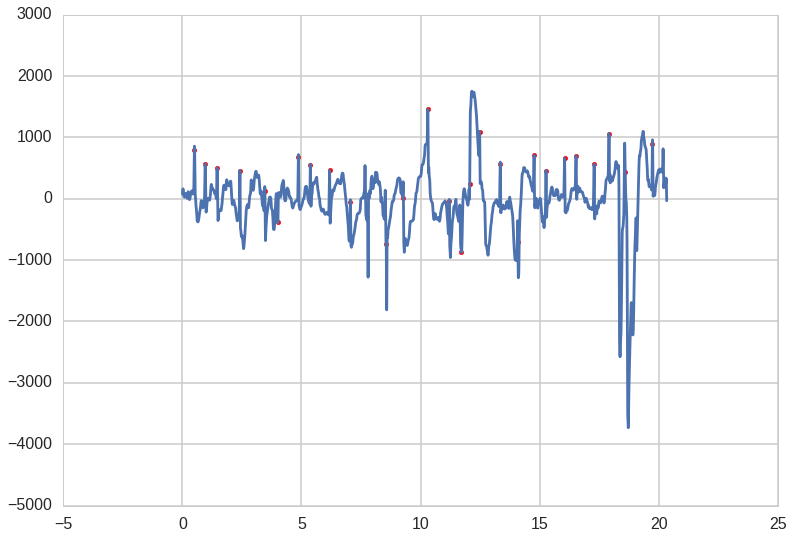

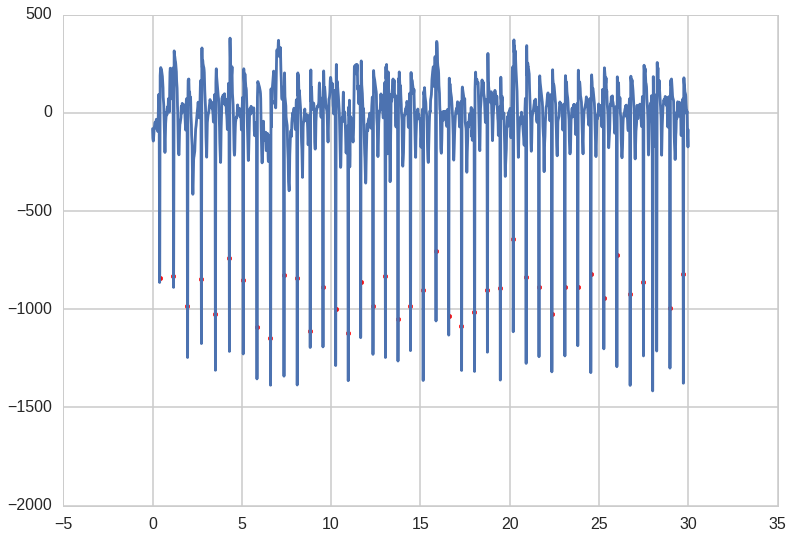

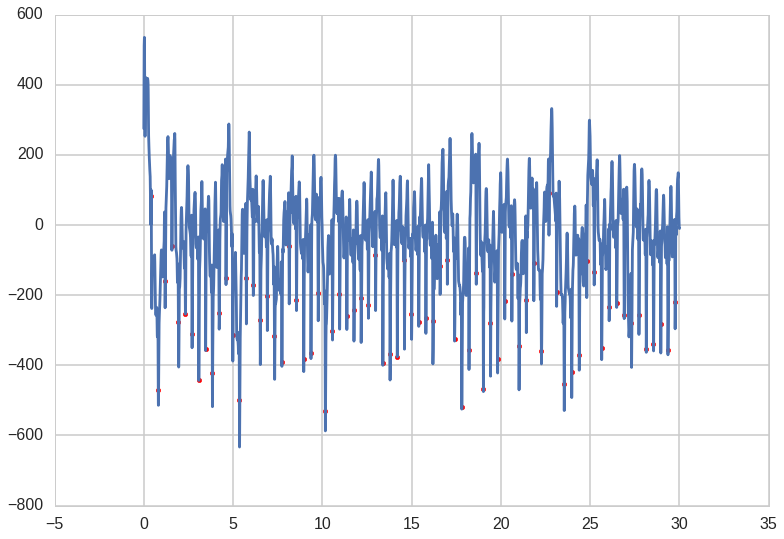

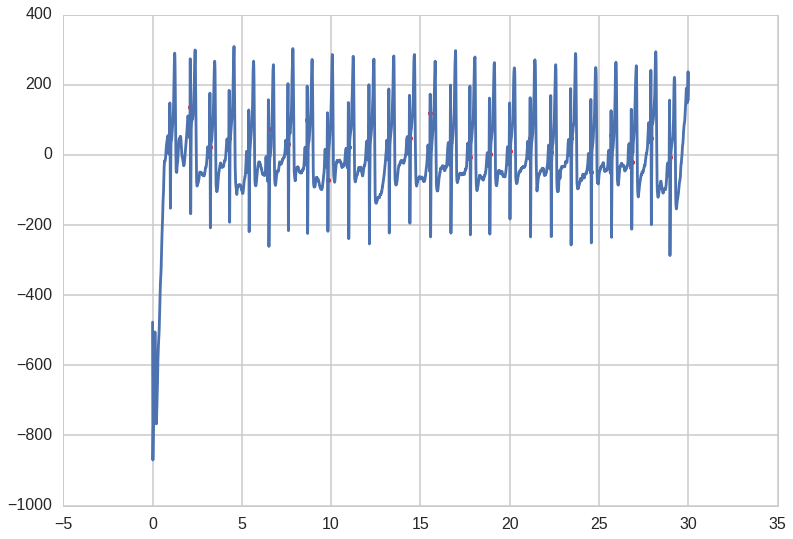

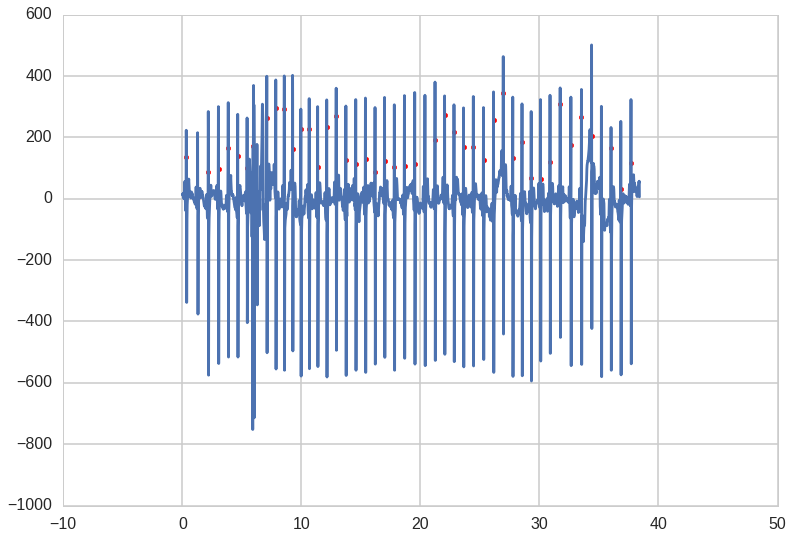

In [32]:
def detect_beats(
        ecg,    # The raw ECG signal
        rate,    # Sampling rate in HZ
        # Window size in seconds to use for 
        ransac_window_size=5.0,
        # Low frequency of the band pass filter
        lowfreq=5.0,
        # High frequency of the band pass filter
        highfreq=15.0,
        ):
    """
    ECG heart beat detection based on
    http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
    with some tweaks (mainly robust estimation of the rectified signal
    cutoff threshold).
    """

    ransac_window_size = int(ransac_window_size*rate)

    lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
    highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
    # TODO: Could use an actual bandpass filter
    ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
    ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
    
    # Square (=signal power) of the first difference of the signal
    decg = np.diff(ecg_band)
    decg_power = decg**2
    
    # Robust threshold and normalizator estimation
    thresholds = []
    max_powers = []
    for i in range(len(decg_power)//ransac_window_size):
        sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
        d = decg_power[sample]
        thresholds.append(0.5*np.std(d))
        max_powers.append(np.max(d))

    threshold = 0.5*np.std(decg_power)
    threshold = np.mean(thresholds)
    max_power = np.mean(max_powers)
    decg_power[decg_power < threshold] = 0

    decg_power /= max_power
    decg_power[decg_power > 1.0] = 1.0
    square_decg_power = decg_power**2 + 1e-10
    #plt.plot(square_decg_power)
    shannon_energy = -square_decg_power*np.log(square_decg_power)
    #plt.plot(shannon_energy)
    shannon_energy[~np.isfinite(shannon_energy)] = 0.0

    mean_window_len = int(rate*0.125+1)
    lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
    #lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
    
    lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
    lp_energy_diff = np.diff(lp_energy)

    zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
    zero_crossings = np.flatnonzero(zero_crossings)
    zero_crossings -= 1
    return zero_crossings
def plot_peak_detection(ecg, rate):
    import matplotlib.pyplot as plt
    dt = 1.0/rate
    t = np.linspace(0, len(ecg)*dt, len(ecg))
    plt.plot(t, ecg)

    peak_i = detect_beats(ecg, rate)
    plt.scatter(t[peak_i], ecg[peak_i], color='red')
    plt.show()
#db = detect_beats(y_val, 300)
for i in range(10, 20):
    plot_peak_detection(loadmat(i), 300)

In [4]:
BPMs = []
for i in range(1, 8500):
    y_val = loadmat(i)
    db = detect_beats(y_val, fs)
    BPM = len(db) * 60 / (len(y_val) / fs)
    BPMs.append(BPM)
    print('\r%d  mean BPM %f'%(i, np.mean(BPMs)), flush=True, end='')

8499  mean BPM 73.795748

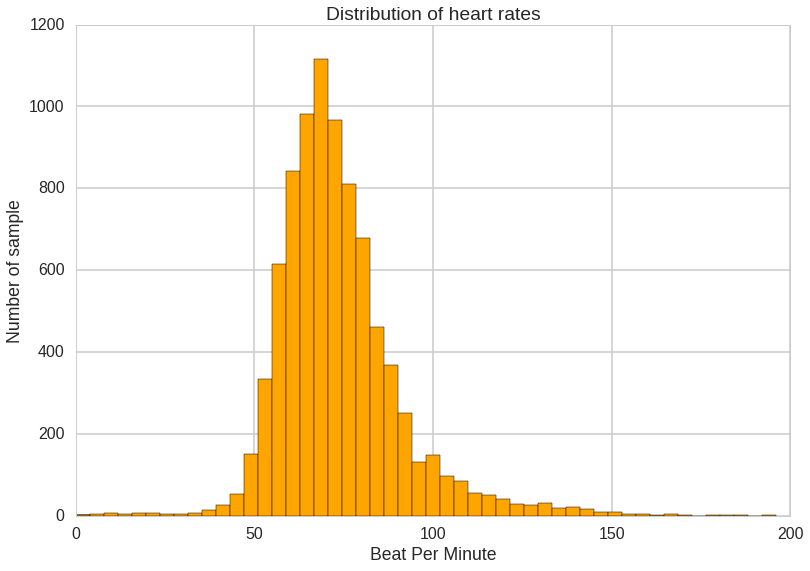

In [33]:
_ = plt.hist(BPMs, bins=50, color='orange')
plt.title('Distribution of heart rates')
plt.ylabel('Number of sample')
plt.xlabel('Beat Per Minute')

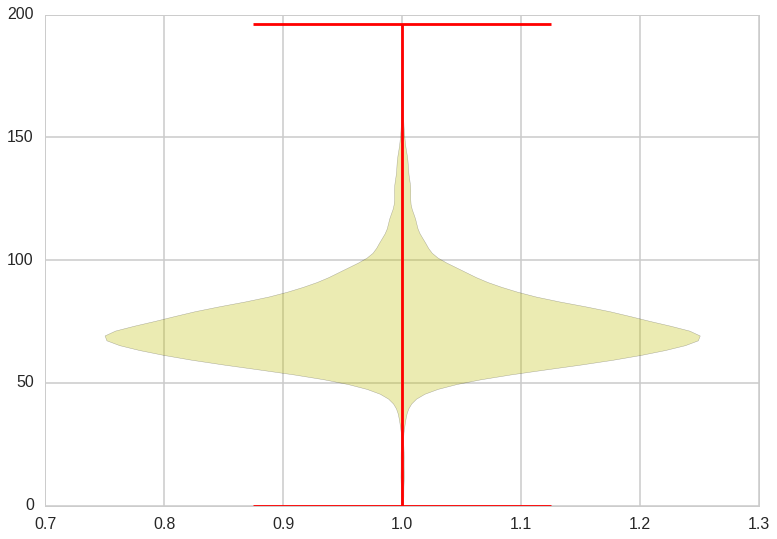

In [34]:
_ = plt.violinplot(BPMs)

In [7]:
def read_raw(refname, dir):
    label_dict = {
        'N': 'Normal',
        'A': 'Fibrillation',
        'O': 'Other',
        '~': 'Noise'
    }

    data = []
    label = []
    lens = []
    annotations = open(refname, 'r').read().splitlines()
    for i, line in enumerate(annotations, 1):
        fname, label_str = line.split(',')
        location = os.path.normpath(dir + '/' + fname + '.mat')
        x = io.loadmat(location)['val'].astype(np.float32).squeeze()
        data.append(x)
        label.append(label_dict[label_str])
        lens.append(len(x))
        if i % 50 == 0:
            print('\rReading files: %5d   ' % i, end='', flush=True)

    print('\rReading files: %5d   ' % i, end='', flush=True)
    assert(len(label) == len(data) == len(lens))
    print('\nReading successful!')
    data_size = len(data)
    data = np.array(data)
    label = np.array(label)
    lens = np.array(lens)

    return data, label
data, label = read_raw('./data/raw/training2017/REFERENCE.csv', './data/raw/training2017/')

Reading files:  8528   
Reading successful!


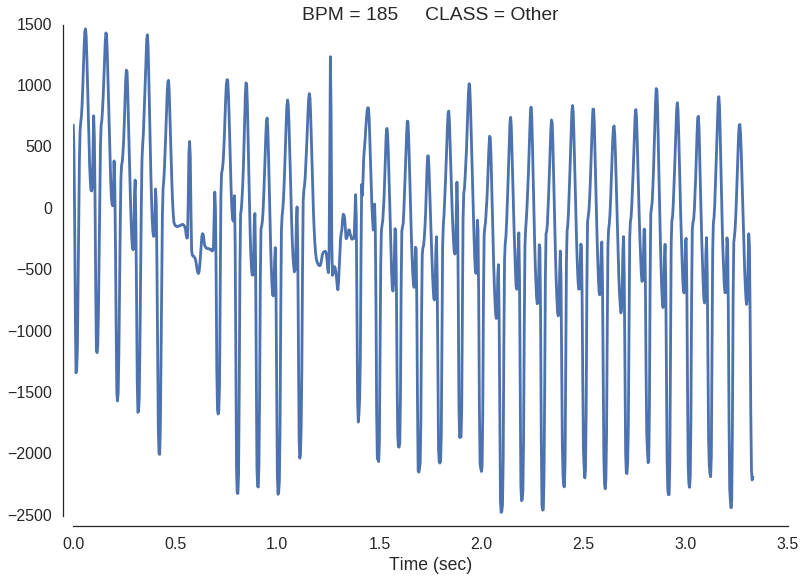

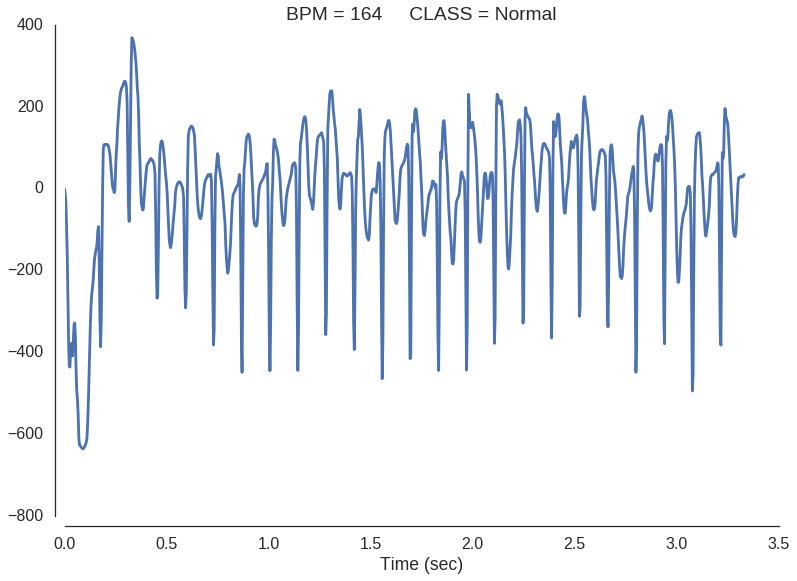

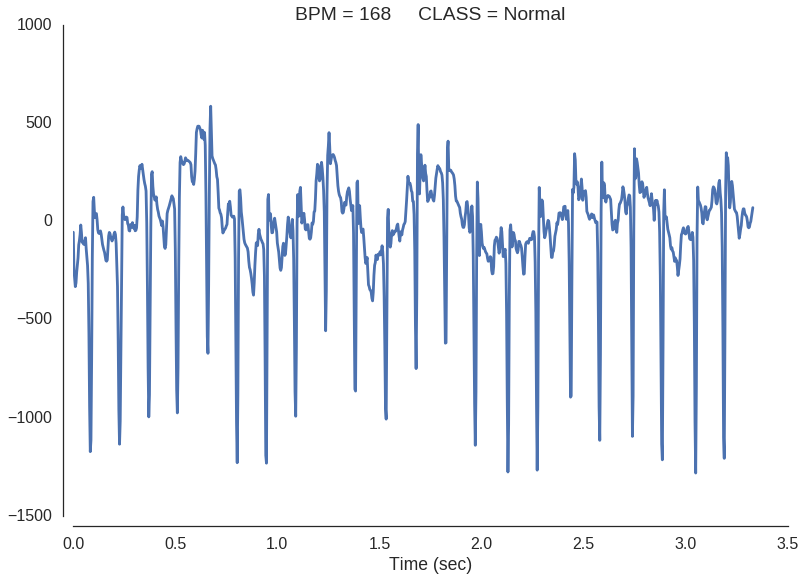

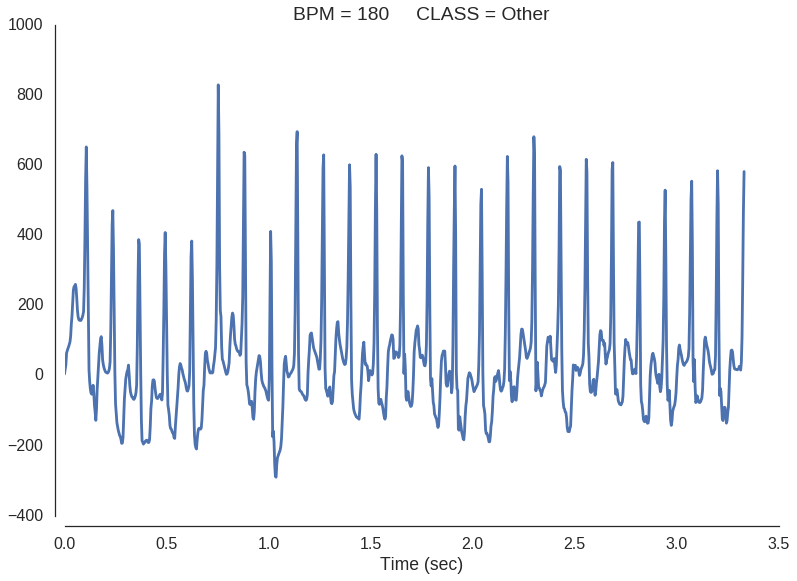

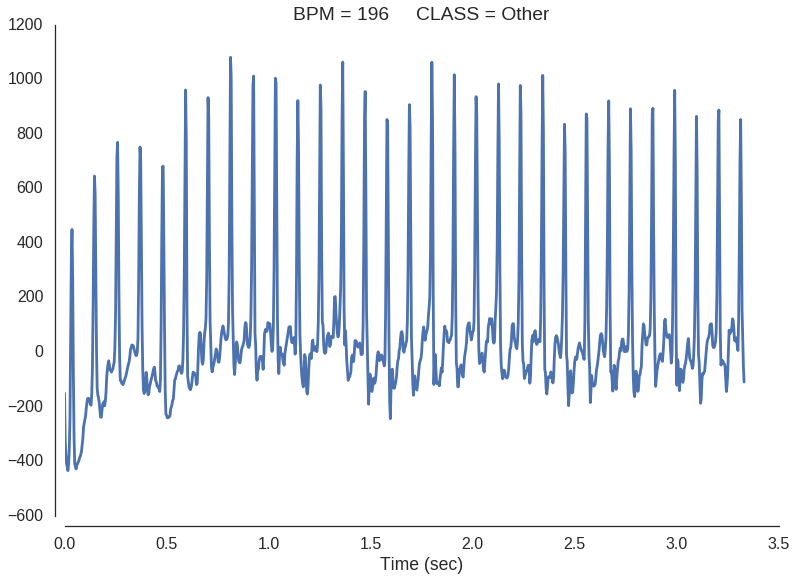

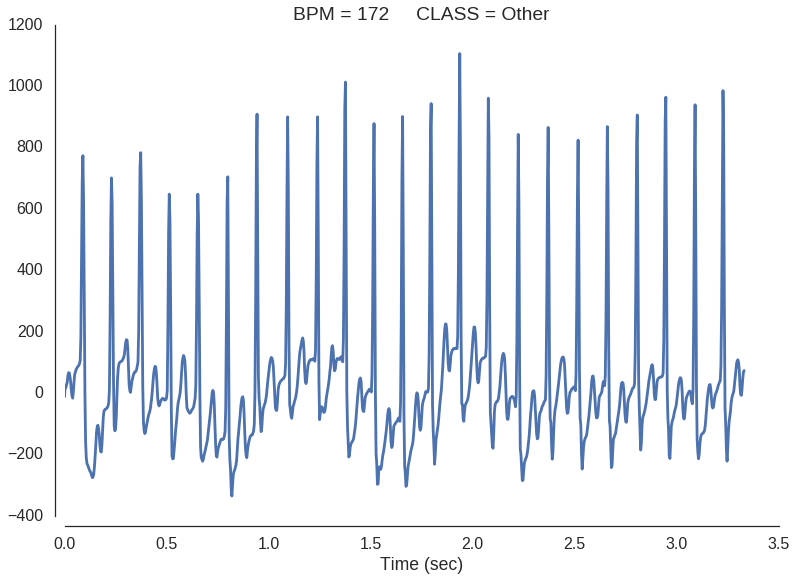

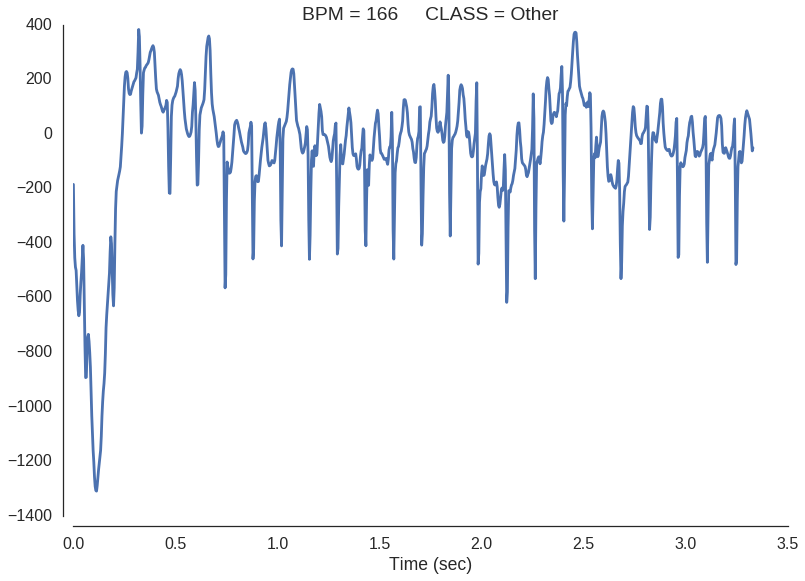

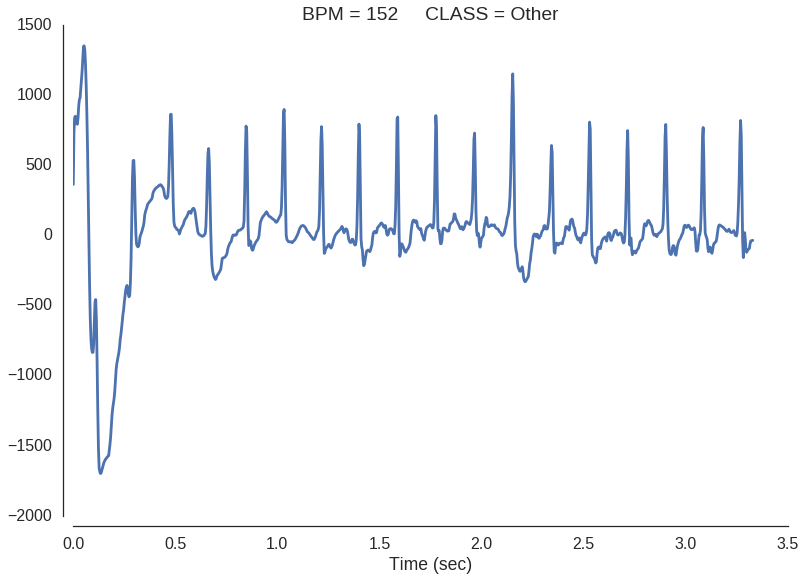

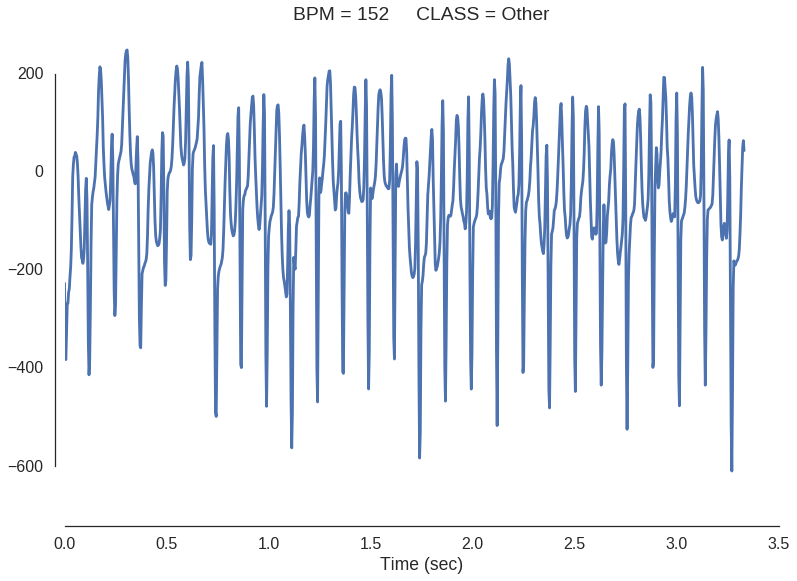

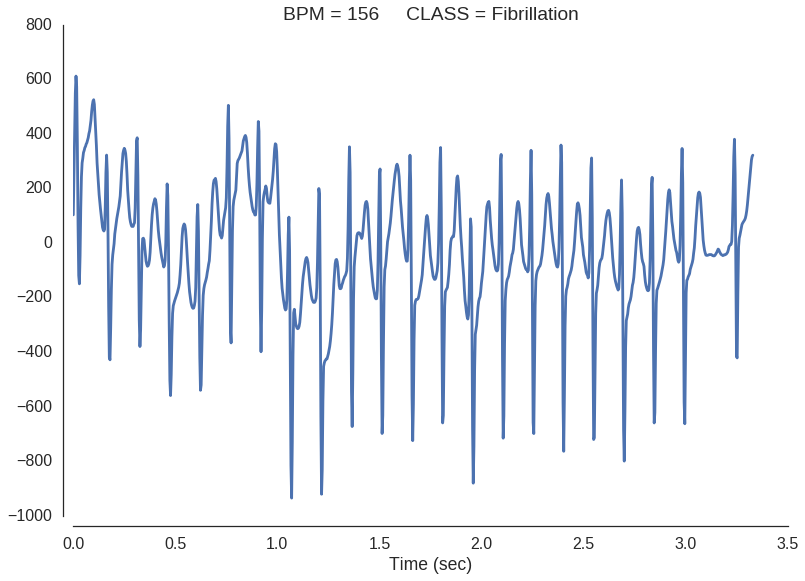

In [38]:
#plt.hist(BPMs, bins=30)
BPMs = np.array(BPMs)
maybe_fibrillation = np.argwhere(BPMs > 150)
for sample_id in maybe_fibrillation[:10]:
    plt.title('BPM = %s     CLASS = %s'%
              (int(BPMs[sample_id][0]), label[sample_id][0]))
    plt.xlabel('Time (sec)')
    y_val = loadmat(sample_id+1)
    y_norm = signal.resample(y_val, len(y_val)//int(BPMs[sample_id])*72)
    plt.plot(np.arange(1000)/300, y_norm[:1000])
    sns.set_style('white')
    sns.despine(offset=10, trim=True);
    plt.show()

In [9]:
class_hist = {
        'Normal': [],
        'Fibrillation': [],
        'Other': [],
        'Noise': []
}

for i in range(8500):
    y_val = loadmat(i+1)
    y_label = label[i]
    db = detect_beats(y_val, fs)
    BPM = len(db) * 60 / (len(y_val) / fs)
    class_hist[y_label].append(BPM)
    print('\r%d'%i, flush=True, end='')

8499

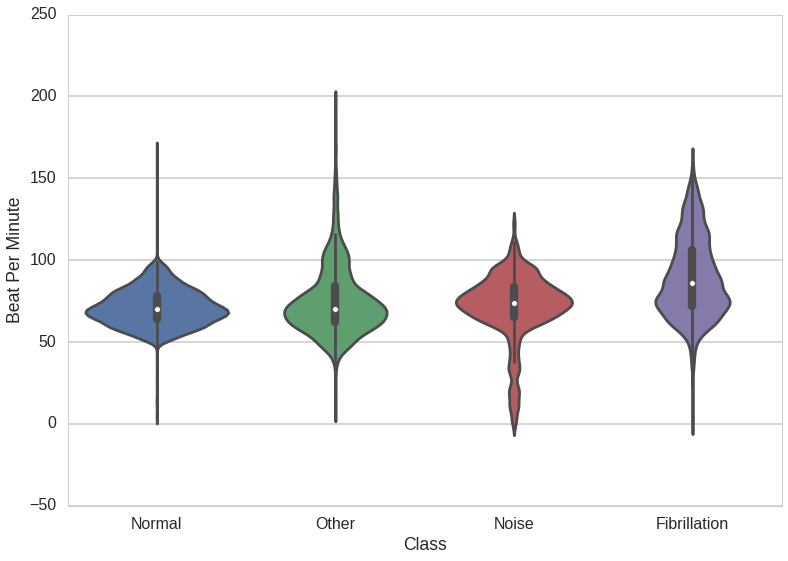

In [30]:
list_class_hist = [[(l, bpm) for bpm in bpms] for l, bpms in class_hist.items()]

df = pd.DataFrame(list(chain(*list_class_hist)), columns=['Class', 'Beat Per Minute'])

#sns.set(font_scale=1.4)
#sns.set_style('whitegrid')
#sns.despine(left=True,  trim=True)
sns.violinplot(x='Class', y='Beat Per Minute', data=df, bw=.17)


In [81]:
def testMarci(y0):

    ## import signal
    fs = 300.
    # PT algorithm

    # LP filter
    b_LPF = [1. / 32] + [0] * 5 + [-1. / 16] + [0] * 5 + [1. / 32]
    a_LPF = [1., -1.99, 1.] + [0] * 10
    y_LP = signal.filtfilt(b_LPF, a_LPF, y0)

    # HP Filter
    b_HPF = [-1. / 32] + [0] * 15 + [1, -1] + [0] * 14 + [1. / 32]
    a_HPF = [1., -0.99] + [0] * 31
    y_HP = signal.filtfilt(b_HPF, a_HPF, y0)

    # Differentiation
    b_DEV = [1. / 4, 1. / 8, 0, -1. / 8, -1. / 4]
    a_DEV = [1] + [0] * 4
    y_DEV = signal.filtfilt(b_DEV, a_DEV, y_HP)

    # Squaring
    y_SQ = y_DEV * y_DEV

    # Smoothing
    b_SM = [1. / 30] * 30
    a_SM = [1] + [0] * 30
    y_SM1 = signal.filtfilt(b_SM, a_SM, y_SQ)
    y_SM2 = signal.filtfilt(b_SM, a_SM, y_SM1)

    # PT Squaring
    y_QRS = (y_HP * y_HP * y_HP) / 200000.
    y_PT = np.asarray(y0)
    
    return y_SM2

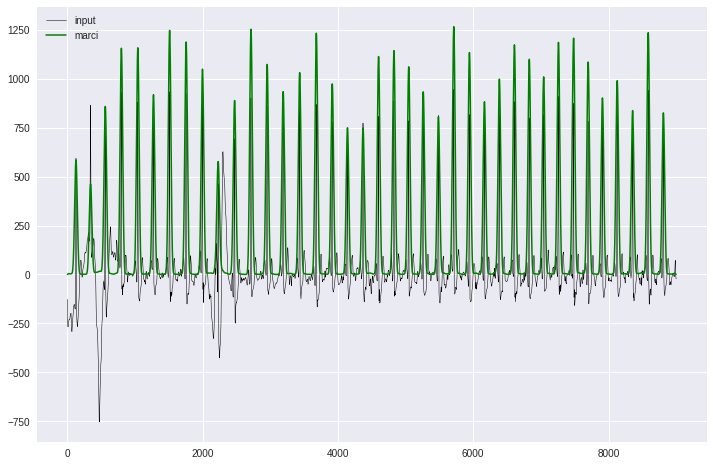

In [22]:
marci_res = testMarci(y_val)
plt.figure(1)
plt.plot(y_val, 'k-', label='input', linewidth=0.5)
plt.plot(marci_res, 'g-', linewidth=1.5, label='marci')
plt.legend(loc='best')
plt.show()